# **DERIVING SPATIAL MAPS WITH PYFLWDIR**

# DATA


In [28]:
import os

# Projection_NZ        = 'EPSG:2193'  # This is the default projection NZGD2000 / New Zealand Transverse Mercator 2000
Input_Static_Root    = "E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\Input"
Dem_Name_Tif         = "Timoleague_DTM_1m.tif"

Root_Output     = "E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\OutputPython"
# Root_Output_Csv      = "D:\MAIN\MODELS\WFLOW\DATA\SouthLand\OutputCsv"

Path_Input_Dem = os.path.join(Input_Static_Root, Dem_Name_Tif)

Option_Subcatchement_OR_Catchement = 'Subcatchement' # 'Subcatchement' 'Catchement'

StreamOrder = 4


## **TOOLS:** *DEM -> FlowDirection (LDD)*

In [30]:
import hydromt
import pyflwdir
import rasterio

def DEM_2_LDD_HYDROMT0(Path_Input, Path_Output, Max_Depth=-1.0, Outlets="edge"):
   
   # Read elevation data using hydromt which will transform the data into xarray     
   Dem = hydromt.io.open_raster(Path_Input)

   Flwdir_D8= hydromt.flw.d8_from_dem(Dem ,max_depth=Max_Depth, outlets=Outlets, idxs_pit=None)
   
   Flwdir_D8.raster.to_raster(Path_Output)
   
   # Read D8 data using rasterio
   with rasterio.open(Path_Output, "r") as src:
      D8 = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile

   # Converting D8 -> ldd
   Flwdir_Ldd_Pyflwdir =pyflwdir.core_conversion.d8_to_ldd(D8)
   
   # Write to tiff file
   prof.update(dtype=Flwdir_Ldd_Pyflwdir.dtype, nodata=False)
   with rasterio.open(Path_Output, "w", **prof) as src:
      src.write(Flwdir_Ldd_Pyflwdir, 1)

   return Flwdir_Ldd_Pyflwdir


In [43]:

import geopandas
import os as os
Path_Input_River_Geojson = os.path.join(Input_Static_Root,"Timoleague_River.geojson")

River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)

River_GeoDataFrame= geopandas.GeoDataFrame(River_Geopandas)


In [52]:
"""Note: This quick solution does require loading the entire flow direction map into memory (Flwdir_D8.load()) which can be a problem for large maps. The implementation inside hydromt_wflow works differently and makes use of options in xarray to perform computations in a chucked way (so loading only chuncks of the maps into memory to perform calculations instead of the whole map)

xarray.apply_ufunc
https://docs.xarray.dev/en/latest/generated/xarray.apply_ufunc.html

"""

import hydromt
import pyflwdir
import xarray

def DEM_2_LDD_HYDROMT(Path_Input, Path_Output, River, Max_Depth=-1.0, Outlets="edge" ):

	# Read elevation data using hydromt which will transform the data into xarray
 
	Dem = hydromt.io.open_raster(Path_Input)
  
	Flwdir_D8= hydromt.flw.d8_from_dem(da_elv=Dem ,max_depth=Max_Depth, gdf_riv=River, outlets=Outlets, idxs_pit=None, riv_burn_method='fixed',riv_depth=0.5)
 
	Flwdir_Ldd_Pyflwdir = xarray.apply_ufunc(pyflwdir.core_conversion.d8_to_ldd, Flwdir_D8.load())
 
	Flwdir_Ldd_Pyflwdir.raster.to_raster(Path_Output)
   
	return Flwdir_Ldd_Pyflwdir


In [53]:
import os as os
Path_Input_Dem = os.path.join(Input_Static_Root, Dem_Name_Tif)
Path_Output_Ldd	= os.path.join(Root_Output, "Ldd_Pyflwdir3.tiff")

Ldd_Pyflwdir = DEM_2_LDD_HYDROMT(Path_Input_Dem, Path_Output_Ldd, River_GeoDataFrame, Max_Depth=-1.0, Outlets="edge")


nodata value missing for E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\OutputPython\Ldd_Pyflwdir3.tiff


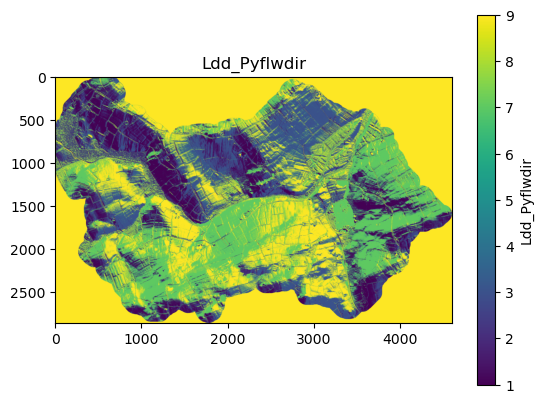

In [36]:

from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show
pyplot.imshow(Ldd_Pyflwdir, cmap='viridis', vmin=1, vmax=9)
pyplot.title('Ldd_Pyflwdir')
pyplot.colorbar(label='Ldd_Pyflwdir')
pyplot.show()


In [ ]:
import rasterio
import numpy as np
import pyflwdir

def DEM_2_LDD_PYFLWDIR(Path_Input_Dem, Path_Output_FlowDirection, Max_Depth=-1.0, Outlets="edge"):
   
	# Read elevation data using rasterio
	with rasterio.open(Path_Input_Dem, "r") as src:
		elevtn = src.read(1)
		nodata = src.nodata
		transform = src.transform
		crs = src.crs
		latlon = src.crs.is_geographic
		prof = src.profile

	# returns FlwDirRaster object
	Ldd_Pyflwdir = pyflwdir.from_dem(data=elevtn, nodata=src.nodata, max_depth=Max_Depth, outlets=Outlets, transform=transform, latlon=latlon)
	
	Ldd_Array = Ldd_Pyflwdir.to_array(ftype="ldd")

	# Write to tiff file
	prof.update(dtype=Ldd_Array.dtype, nodata=False)
	with rasterio.open(Path_Output_FlowDirection, "w", **prof) as src:
		src.write(Ldd_Array, 1)

	return Ldd_Pyflwdir, Ldd_Array


## **TOOLS:** *DEM -> SLOPE*

In [ ]:
import rasterio
import pyflwdir

def DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope):
 
 	# Read elevation data using rasterio
	with rasterio.open(Path_Input_Dem, "r") as src:
		elevtn = src.read(1)
		nodata = src.nodata
		transform = src.transform
		crs = src.crs
		#  extent = np.array(src.bounds)[[0, 2, 1, 3]]
		latlon = src.crs.is_geographic
		prof = src.profile
 
	Slope_Pyflwdir = pyflwdir.dem.slope(elevtn, nodata=src.nodata, latlon=latlon, transform=transform)
 
 	# Write to tiff file
	prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
	with rasterio.open(Path_Output_Slope, "w", **prof) as src:
		src.write(Slope_Pyflwdir, 1)
 
	return Slope_Pyflwdir


## **TOOLS:** *FlowDirection -> Streams*

In [ ]:
import rasterio
import pyflwdir
import numpy as np

def FLOWDIRECTION_2_STREAMS(FlowDirection_Pyflwdir, Path_Input_Dem, Path_Output_StreamOrder, Path_Output_StreamSlope, Path_Output_StreamWidth, Path_Output_StreamTrue, Slope_Pyflwdir, StreamOrder=4, StreamOrderMin=1, StreamWidth=2.0, Type='strahler'):
   #  Type= "strahler" or "classic"
   
   # Read elevation data using rasterio   
   with rasterio.open(Path_Input_Dem, "r") as src:
      elevtn = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile
   
   # === STREAM ORDERS ===================================
   Streams_StreamOrder = FlowDirection_Pyflwdir.stream_order(type=Type)
   
   # Masking data were Stream order > 1
   Nx,Ny = np.shape(Streams_StreamOrder)
   Streams_StreamOrder2 = np.ma.empty(shape=(Nx, Ny))
   for iX in range(Nx):
      for iY in range(Ny):
         if Streams_StreamOrder[iX,iY] > StreamOrderMin:
            Streams_StreamOrder2[iX,iY] = Streams_StreamOrder[iX,iY]
   
   prof.update(dtype=Streams_StreamOrder.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamOrder, "w", **prof) as src:
      src.write(Streams_StreamOrder2, 1)
      
   # === STREAMS TRUE ==================================
   Streams = np.greater(Streams_StreamOrder, StreamOrder)
   
   prof.update(dtype=Streams_StreamOrder.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamTrue, "w", **prof) as src:
      src.write(Streams, True)
   
   # === STREAMS WIDTH ===     
   Streams_Width = Streams * StreamWidth
   prof.update(dtype=Streams_StreamOrder.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamWidth, "w", **prof) as src:
      src.write(Streams_Width, 1)
      
	# === STREAM SLOPE ====  
   Nx,Ny = np.shape(Streams)
   Streams_Slope = np.ma.empty(shape=(Nx, Ny))
   
   # Masking only data were we have slope
   for iX in range(Nx):
      for iY in range(Ny):
         if Streams[iX,iY]==True:
            Streams_Slope[iX,iY] = Slope_Pyflwdir[iX,iY]

   
   prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamSlope, "w", **prof) as src:
      src.write(Streams_Slope, 1) 
      
   return Streams, Streams_Slope, Streams_StreamOrder, Streams_Width
   

## **TOOLS:** *FlowDirections -> Catchements*

In [ ]:
# import geopandas as gpd
import numpy as np
import geopandas as gpd
import rasterio
import pyflwdir
# import python_utils
import os as os

def FLOWDIRECTION_2_CATCHEMENT(FlowDirection_Pyflwdir, Path_Input_Dem, Path_Output_Catchment, Xcoord = 147704.593,  Ycoord = 41038.670, Option_Catchement="Subbasins", Crs=29902 ):
  
   # Read elevation data using rasterio   
   with rasterio.open(Path_Input_Dem, "r") as src:
      elevtn = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile
      
	# # Define output location
 	# # x,y = np.array([Xcoord, Ycoord])
  
	# gdf_out = gpd.GeoSeries(gpd.points_from_xy(x, y, crs=Crs))
 
	# # delineate subbasins
	# subbasins = FlowDirection_Pyflwdir.basins(xy=(x, y), streams=FlowDirection_Pyflwdir.stream_order() >= 4)
	# # vectorize subbasins using the vectorize convenience method from utils.py
	# gdf_bas = vectorize(subbasins.astype(np.int32), 0, FlowDirection_Pyflwdir.transform, name="basin")
	# gdf_bas.head()
   
   # # # Delinating catchements
   # # if  Option_Catchement == "Subbasins":
   # #    Subbassins, Idxs_out = FlowDirection_Pyflwdir.subbasins_streamorder(min_sto=7, mask=None)
   
   # # prof.update(dtype=Subbassins.dtype, nodata=False)
   # # with rasterio.open(Path_Output_Catchment, "w", **prof) as src:
   # #    src.write(Subbassins, 1) 
   
   # # return Subbassins, Idxs_out
	# return gdf_bas


# =========================================================================================================

## DEM TASKS

### Flow directions

In [ ]:

import os as os
Path_Input_Dem = os.path.join(Input_Static_Root, Dem_Name_Tif)
Path_Output_Ldd    = os.path.join(Root_Output, "Ldd.tiff")
Ldd_Hydromt = DEM_2_LDD_HYDROMT(Path_Input_Dem, Path_Output_Ldd, Max_Depth=-1.0, Outlets="edge")


In [ ]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show
pyplot.imshow(Ldd_Hydromt, cmap='viridis', vmin=1, vmax=100)
pyplot.title('Ldd')
pyplot.colorbar(label='Ldd')
pyplot.show()


In [ ]:
import os as os
Path_Input_Dem = os.path.join(Input_Static_Root, Dem_Name_Tif)
Path_Output_Ldd    = os.path.join(Root_Output, "Ldd.tiff")

Ldd_Pyflwdir, Ldd_Array = DEM_2_LDD_PYFLWDIR(Path_Input_Dem, Path_Output_Ldd, Max_Depth=-10.0, Outlets="min")



In [ ]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show
pyplot.imshow(Ldd_Array, cmap='viridis', vmin=1, vmax=9)
pyplot.title('Ldd')
pyplot.colorbar(label='Ldd')
pyplot.show()


### Slope 

In [ ]:

Path_Output_Slope = os.path.join(Root_Output, "Slope.tiff")
Slope_Pyflwdir = DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope)


In [ ]:
import numpy as np
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show
pyplot.imshow(np.log(Slope_Pyflwdir), vmin=0, vmax=1)
pyplot.title('Slope')
pyplot.colorbar(label='Slope')
pyplot.show()


### Streams

In [ ]:
Path_Output_StreamOrder = os.path.join(Root_Output, "StreamOrder.tiff")
Path_Output_StreamSlope = os.path.join(Root_Output, "StreamSlope.tiff") 
Path_Output_StreamWidth = os.path.join(Root_Output, "StreamWidth.tiff")
Path_Output_StreamTrue = os.path.join(Root_Output, "StreamTrue.tiff")

Streams, Streams_Slope, Streams_StreamOrder, Streams_Width = FLOWDIRECTION_2_STREAMS(Ldd_Pyflwdir, Path_Input_Dem, Path_Output_StreamOrder, Path_Output_StreamSlope, Path_Output_StreamWidth, Path_Output_StreamTrue, Slope_Pyflwdir, StreamOrder=7,  StreamOrderMin=1, StreamWidth=2.0, Type='strahler')


In [ ]:
pyplot.imshow(Streams_StreamOrder, cmap='viridis', vmin=1, vmax=10)
pyplot.title('StreamOrder')
pyplot.colorbar(label='StreamOrder')


In [ ]:
pyplot.imshow(Streams_StreamOrder, cmap='viridis', vmin=1, vmax=10)
pyplot.title('StreamOrder')
pyplot.colorbar(label='StreamOrder')


### Catchement boundary

In [ ]:
Path_Output_Catchment = os.path.join(Root_Output, "Catchment.tiff")
Subbassins, Idxs_out = FLOWDIRECTION_2_CATCHEMENT(FlowDirection_Pyflwdir, Path_Input_Dem, Path_Output_Catchment, Option_Catchement="Subbasins")


#### DEM data: *wflow_dem*


### River network

#### Gauges stations: *wflow_gauges_grdc*

#### ldd maps: *wflow_ldd*

### Looking for pits

#### Subcatchement: *wflow_subcatch*

### Reduce extend based on catchment


### River network

##### Slope: *Slope*

### MAPS derived from rivers

#### River location: *wflow_river*

#### River length: *wflow_riverlength*

#### River width: *wflow_riverwidth*


#### River slope: *RiverSlope*

## OUTPUT CSV

## NetCDF Static data

## FORCING DATA

### Precipitation


#### Potential evapotranspiration